##Fine Tuning

In several machine learning applcations, state of the art modles that work on "similar" problems are available.

Rather than training a network from scratch, it is worthwhile to use the already available model, albeit they are for a slightly different problem

This is called transfer learning. Possibly the simplest form of transfer learning is Fine-tuning where we make minor adjustments to a network and use it for a new problems.

Fine-tuning is especially effective in cases where limited data is available.

Let's explore example of fine-tunign below. We will fine-tune resent18 trained on imagenet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary


In [ ]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])

    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])


    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



In [ ]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz)

100%|██████████| 9912422/9912422 [00:00<00:00, 175646538.22it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 128185919.39it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 127139705.06it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 10473077.94it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



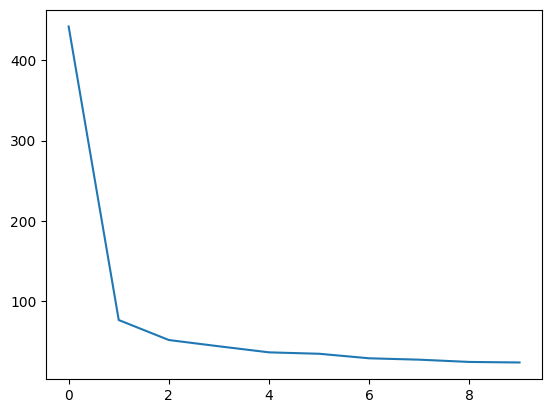

In [ ]:
device = torch.device("cuda:0")
net = models.resnet18(num_classes = 10)
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

net =net.to(device)

lr = 0.1
momentum = 0.5
num_epochs = 10

opt = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net(X)
    loss = F.cross_entropy(logits, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss)


plt.plot(ls)



In [ ]:
#finetuning here
# feature extactor ----> classifier
net = models.resnet18(pretrained = True)
print(net)


#freezing the network (backbone)
for params in net.parameters():
  params.requires_grad = False




net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.fc = nn.Linear(in_features=512, out_features=10, bias=True)


for name, params in net.named_parameters():
  print(name, params.requires_grad)



In [ ]:
#   ------>gard fc

# opt.step() ---> negative gradient only all parameter

In [ ]:

#traininign the classifier (in our case due to the channel mismatch we are trianing hte first layer as well)
device = torch.device("cuda:0")
net = net.to(device)

lr = 0.1
momentum = 0.5
num_epochs = 2

opt = torch.optim.SGD(net.parameter() , lr = lr, momentum = momentum)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net(X)
    loss = F.cross_entropy(logits, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss)

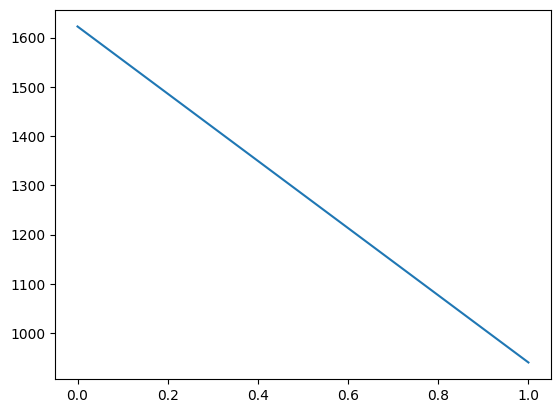

In [ ]:
plt.plot(ls)

In [ ]:
summary(net, X.shape[1:],)

In [ ]:
#unfreezing
for params in net.parameters():
  params.requires_grad = True

In [ ]:
#fine tuning full network
device = torch.device("cuda:0")
net = net.to(device)

lr = 0.01
momentum = 0.5
num_epochs = 5

opt = torch.optim.SGD(net.parameters() , lr = lr, momentum = momentum)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net(X)
    loss = F.cross_entropy(logits, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))

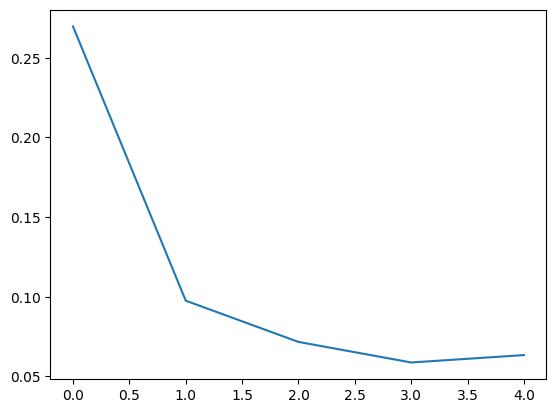

In [ ]:
plt.plot(ls)

In [ ]:
# D1 ---> D2 ---> D3 ----> D4

# M1 ----> M2----> M3 ---->M4

# D1--->D2={D1, N2}---->D3 = {D2, N3} ---->D4 = {D3, N4}

# Et \subset D_{t-1}

# L_{Nt} ---> without fogetting (L_{D_{t-1}}, should also be small)

# min L_{Nt} s.t. |theta - theat_{t-1}|_2^2 < eps

# min {L_{Nt_Et}} # Arslan Chaudary (Deepmind)